# Masking of Leaf Images

In [ ]:
import numpy as np
import torch
import cv2
import kornia as K
import matplotlib.pyplot as plt

from utils import convert_image_to_tensor, convert_img_tensor_to_numpy, crop_img, crop_coords_zero_borders
from masking import keypoints_roi_to_image, scale_image, mask_leaf, erode_crop_leaf, crop_ROI_erode_leaf, fetch_image_mask_pair
from loftr import loftr_match, tps_skimage
from plotting import plot_image_pair, plot_overlay, plot_matches, plot_matches_conf, plot_match_coverage
from DatasetTools.LeafImageSeries import LeafDataset

In [2]:
leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    # leaf_uid="ESWW0090057_18", 
    leaf_uid="ESWW0070020_1",
    # leaf_uid="ESWW0070023_6", 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('target_images', 'target_masks', 'leaf_masks', 'seg_masks', 'cropped_images', 'rois', 'images', 'keypoints'),
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...


Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading images...
Loading cropped images...
Loading ROIs...
Loading Target Masks...
Loading Leaf Masks...
Loading Segmentation Masks...
Loading target images...
Loading keypoints...


## Piecewise Affine

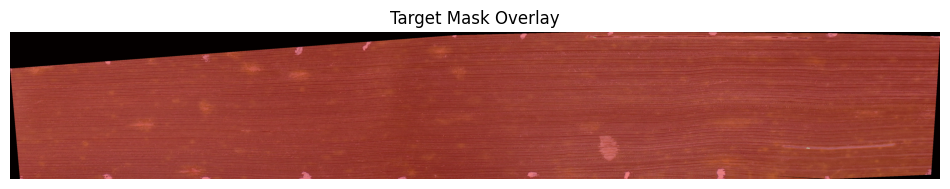

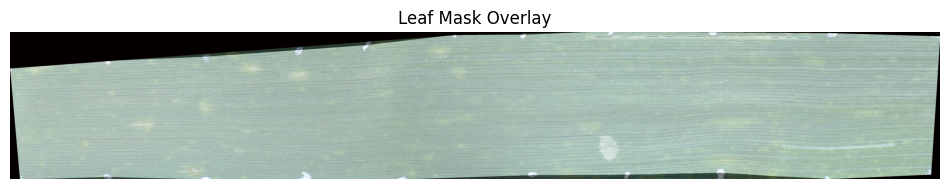

tensor([0., 1.])


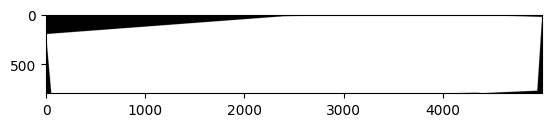

In [5]:
ind = 2
fig = plot_overlay(leaf.target_images[ind], leaf.target_masks[ind], title="Target Mask Overlay")
fig = plot_overlay(leaf.target_images[ind], leaf.leaf_masks[ind], title="Leaf Mask Overlay")
mask = convert_image_to_tensor(leaf.target_masks[ind])
mask[mask!=0] = 1
print(mask.unique())
# plt.imshow(leaf.target_masks[ind])
plt.imshow(convert_img_tensor_to_numpy(mask), cmap='gray', vmin=0, vmax=1)
# plot_image_pair(convert_image_to_tensor(leaf.target_images[ind]), convert_image_to_tensor(leaf.leaf_masks[ind]))

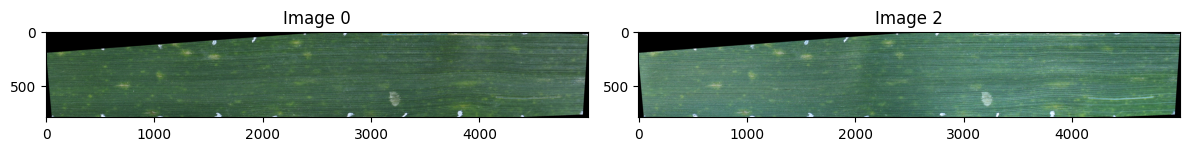

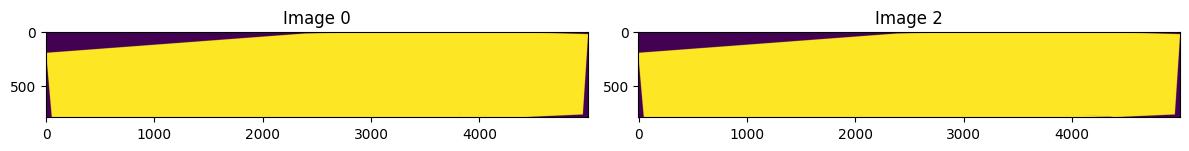

In [8]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 1, 2, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, moving, 0, 2)
fig.show()
fig, ax = plot_image_pair(fixed_mask, moving_mask, 0, 2)
fig.show()

## LoFTR + TPS Full Leaf

### Mask

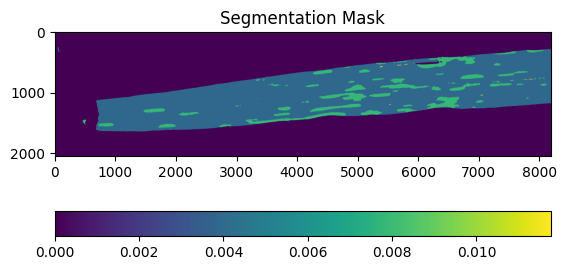

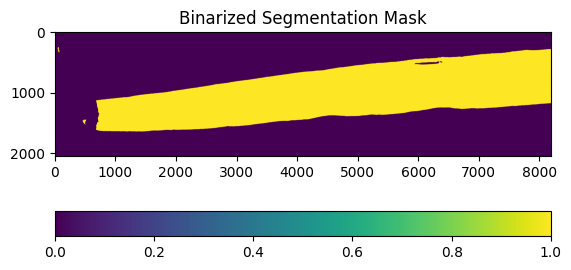

In [9]:
test = leaf.seg_masks[-1]
# test = np.array(test)
test = convert_image_to_tensor(test)
img = plt.imshow(K.tensor_to_image(test))
plt.colorbar(img, orientation='horizontal', fraction=.1)
plt.title("Segmentation Mask")
plt.show()
test[test!=0] = 1
img = plt.imshow(K.tensor_to_image(test))
plt.colorbar(img, orientation='horizontal', fraction=.1)
plt.title("Binarized Segmentation Mask")
plt.show()

### Cropping out black borders

rows: 250, 1643
cols: 42, 8191


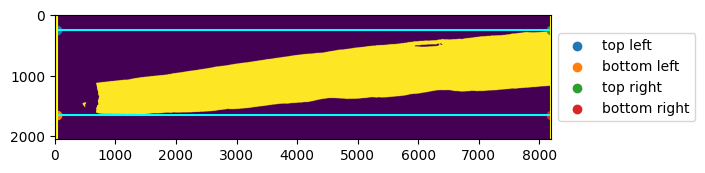

In [10]:
mask = torch.any(test != 0, dim=0)

rows = torch.any(mask != 0, dim=2)
cols = torch.any(mask != 0, dim=1)

r_idx = torch.where(rows[0])[0]
c_idx = torch.where(cols[0])[0]

rmin, rmax = r_idx[0], r_idx[-1]
cmin, cmax = c_idx[0], c_idx[-1]

print(f"rows: {rmin}, {rmax}")
print(f"cols: {cmin}, {cmax}")

plt.imshow(K.tensor_to_image(test))
plt.scatter(cmin, rmin, label='top left')
plt.scatter(cmin, rmax, label='bottom left')
plt.scatter(cmax, rmin, label='top right')
plt.scatter(cmax, rmax, label='bottom right')
plt.hlines([rmin, rmax], 0, 8191, color='cyan')
plt.vlines([cmin, cmax], 0, 2047, color='yellow')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

cropped: torch.Size([1, 1, 1394, 8150])


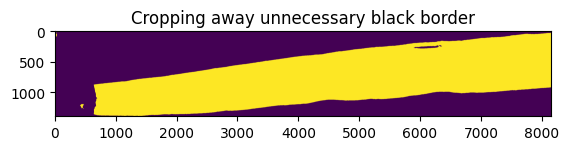

In [11]:
cropped = crop_img(test, cmin, cmax, rmin, rmax)
print(f"cropped: {cropped.shape}")
plt.imshow(K.tensor_to_image(cropped))
plt.title("Cropping away unnecessary black border")
plt.show()

In [12]:
crop_coords_zero_borders(test)

(tensor(250), tensor(1643), tensor(42), tensor(8191))

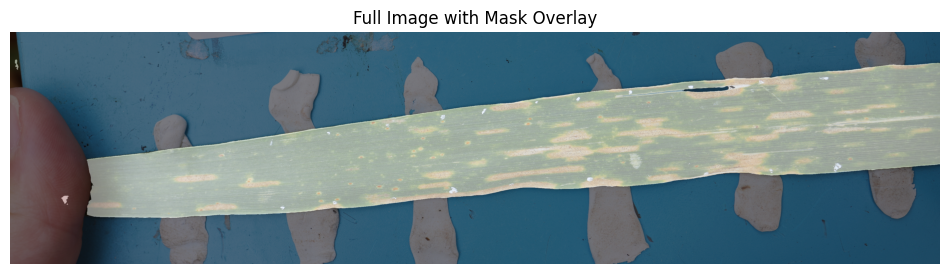

In [13]:
fig = plot_overlay(leaf.cropped_images[-1], test, title="Full Image with Mask Overlay")

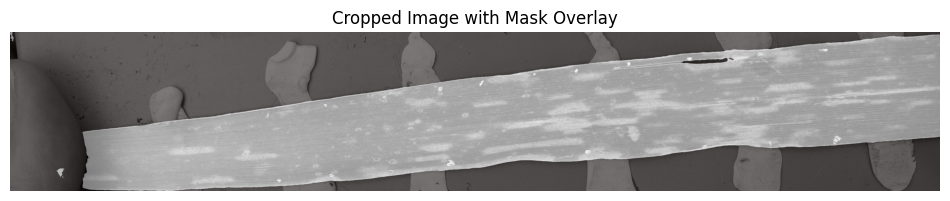

In [14]:
img = convert_image_to_tensor(leaf.cropped_images[-1])
cropped_mask = crop_img(test, cmin, cmax, rmin, rmax)
cropped_img = crop_img(img, cmin, cmax, rmin, rmax)
fig = plot_overlay(cropped_img, cropped_mask, title="Cropped Image with Mask Overlay")

## LoFTR + TPS Region Of Interest

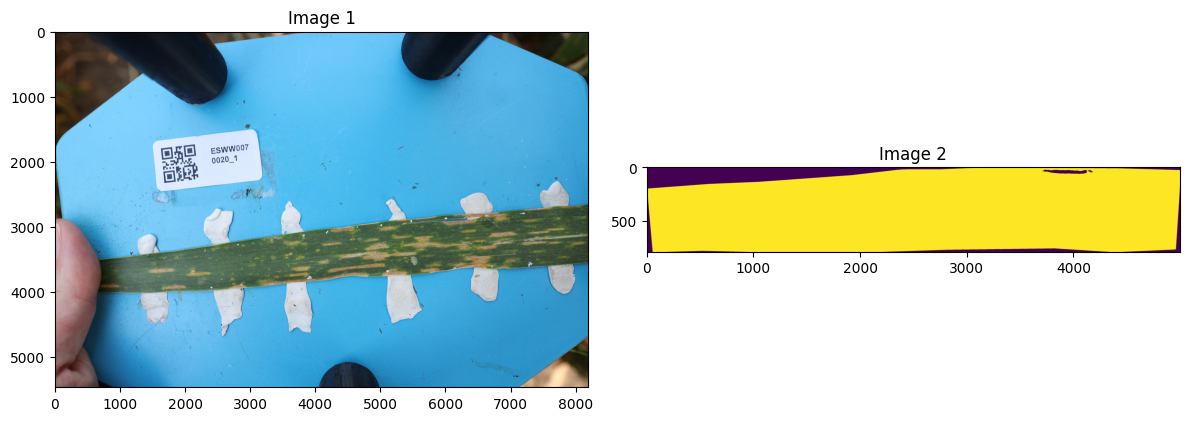

In [16]:
# ind = 1
ind = 13
og_leaf = convert_image_to_tensor(leaf.images[ind])
leaf_mask = convert_image_to_tensor(leaf.leaf_masks[ind])
fig, ax = plot_image_pair(og_leaf, leaf_mask)
fig.show()

### Rotate and Crop Image to ROI

In [17]:
roi = leaf.rois[ind]
rot_mat = np.asarray(roi["rotation_matrix"])
bbox = np.asarray(roi["bounding_box"])
rows, cols = og_leaf.shape[0], og_leaf.shape[1]

#### OpenCV

5464 8192
[[ 9.97469068e-01 -7.11017495e-02  2.04616678e+02]
 [ 7.11017495e-02  9.97469068e-01 -2.84318259e+02]]


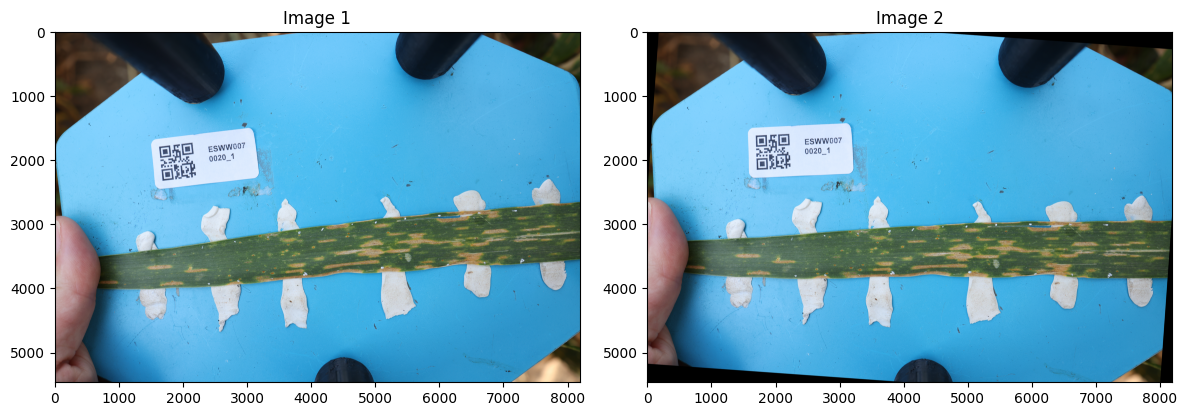

In [18]:
leaf_np = K.tensor_to_image(og_leaf)
rows, cols = leaf_np.shape[0], leaf_np.shape[1]

print(rows, cols)
print(rot_mat)
img_rot_cv = cv2.warpAffine(leaf_np, rot_mat, (cols, rows))
_ = plot_image_pair(convert_image_to_tensor(leaf_np), convert_image_to_tensor(img_rot_cv))

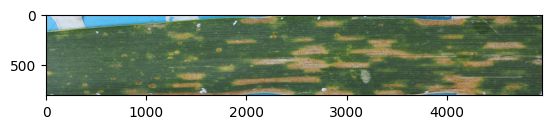

In [19]:
img_rot_cv_crop = img_rot_cv[bbox[0][1]:bbox[2][1], bbox[0][0]:bbox[1][0]]
plt.imshow(img_rot_cv_crop)

#### Kornia

5464 8192
[[ 9.97469068e-01 -7.11017495e-02  2.04616678e+02]
 [ 7.11017495e-02  9.97469068e-01 -2.84318259e+02]]


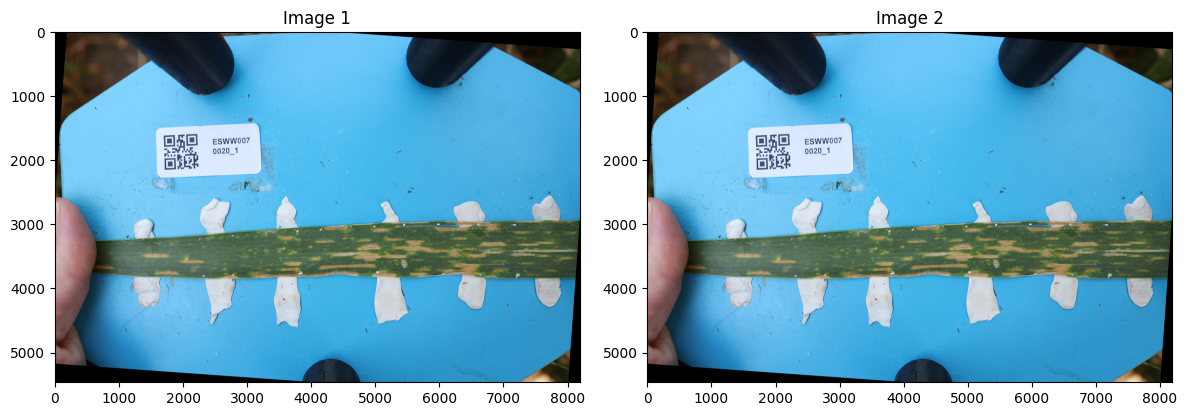

In [20]:
H, W = og_leaf.shape[2], og_leaf.shape[3]

print(rows, cols)
print(rot_mat)
img_rot_K = K.geometry.transform.warp_affine(og_leaf, torch.Tensor(rot_mat).unsqueeze(0), (H, W)) #, align_corners=True)
_ = plot_image_pair(convert_image_to_tensor(img_rot_K), convert_image_to_tensor(img_rot_cv))

In [21]:
print(bbox)
print(bbox[:,0].max())

[[2261 3005]
 [7212 3005]
 [7212 3809]
 [2261 3809]]
7212


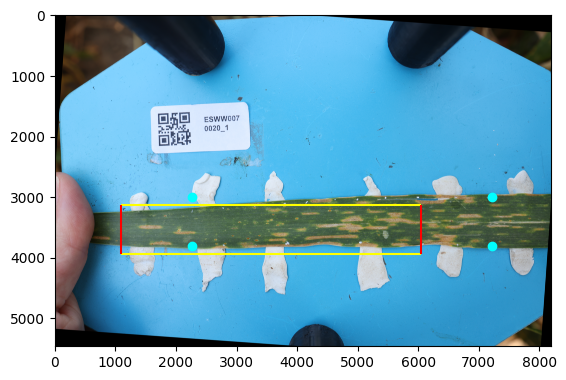

In [22]:
plt.imshow(img_rot_cv)
plt.hlines(y=[3124, 3942], xmin=1086, xmax=6045, color='yellow')
plt.vlines(x=[1086, 6045], ymin=3124, ymax=3942, color='red')
plt.scatter(bbox[:,0], bbox[:,1], color='cyan')
plt.show()

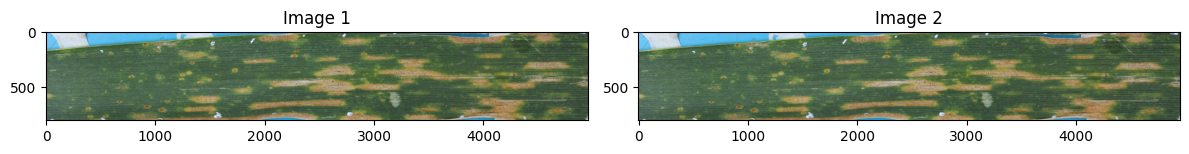

In [23]:
img_rot_K_crop = crop_img(img_rot_K, bbox[:,0].min(), bbox[:,0].max(), bbox[:,1].min(), bbox[:,1].max())
fig, ax = plot_image_pair(img_rot_K_crop, convert_image_to_tensor(img_rot_cv_crop))

### Leaf Mask?

In [24]:
img_shape = convert_image_to_tensor(img_rot_cv_crop).shape
mask_shape = convert_image_to_tensor(leaf.leaf_masks[ind]).shape
print(f"cropped image shape: {img_shape}")
print(f"leaf mask shape: {mask_shape}")
diff = [sa - sb for sa, sb in zip(img_shape, mask_shape)]
print(f"size diff = {diff[2:]}")

cropped image shape: torch.Size([1, 3, 804, 4951])
leaf mask shape: torch.Size([1, 1, 791, 4999])
size diff = [13, -48]


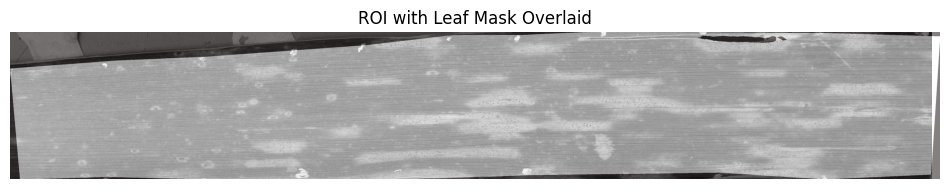

In [25]:
fig = plot_overlay(convert_image_to_tensor(img_rot_cv_crop), convert_image_to_tensor(leaf.leaf_masks[ind]), title="ROI with Leaf Mask Overlaid")

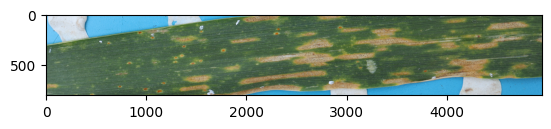

In [26]:
# crop without rotate
img_crop = leaf_np[bbox[0][1]:bbox[2][1], bbox[0][0]:bbox[1][0]]
plt.imshow(img_crop)
# fig = plot_overlay(convert_image_to_tensor(img_crop), convert_image_to_tensor(leaf.leaf_masks[ind]))
plt.show()

tensor(13848.)


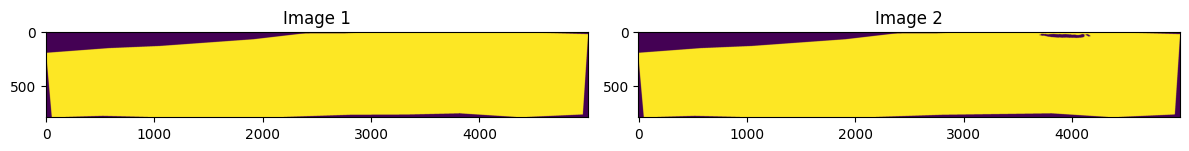

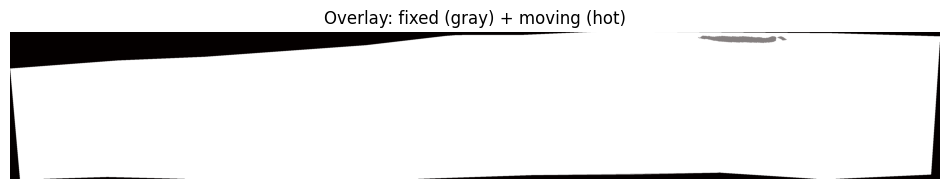

In [27]:
# comparing different leaf masks in the sequence
mask1 = convert_image_to_tensor(leaf.leaf_masks[1])
mask2 = convert_image_to_tensor(leaf.leaf_masks[13])
plot_image_pair(mask1, mask2)
print(torch.abs(torch.sum(mask1-mask2)))
_ = plot_overlay(mask1.repeat(1,3,1,1), mask2)
# plt.imshow(K.tensor_to_image(torch.abs(convert_image_to_tensor(leaf.leaf_masks[1])-convert_image_to_tensor(leaf.leaf_masks[11]))), cmap='Grays')
# plt.show()

## Using Keypoints to for Full Image Mask

### Aligning Keypoints

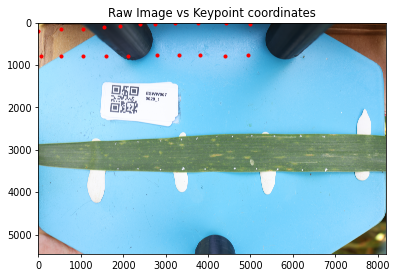

In [28]:
index = 4
plt.figure(dpi=70)
plt.imshow(leaf.images[index])
plt.scatter(leaf.keypoints[index][:,0], leaf.keypoints[index][:,1], c='red', s=10 )
plt.title("Raw Image vs Keypoint coordinates")
plt.show()

In [32]:
# convert keypoint coords to full image coords
kpts_img = keypoints_roi_to_image(leaf.keypoints[index], leaf.rois[index])

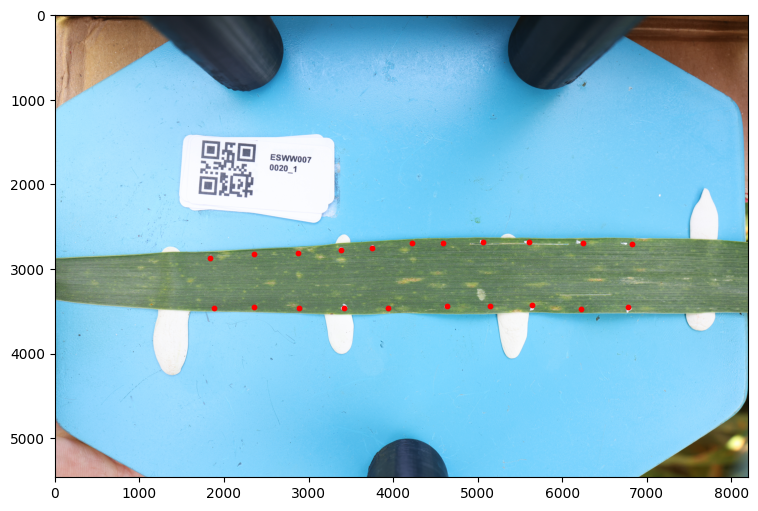

In [34]:
plt.figure(figsize=(12,6))
plt.imshow(leaf.images[index])
plt.scatter(kpts_img[:,0], kpts_img[:,1], c='red', s=10 )
plt.show()

### Masking

In [38]:
masked_img, mask_t, center = mask_leaf(leaf.images[index], kpts_img, erode_px=0)

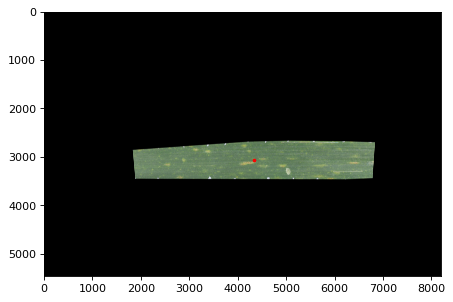

In [41]:
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_img))
plt.scatter(center[0], center[1], c='red', s=5, label='center')
# plt.scatter(mean[0][0], mean[0][1], c='yellow', s=5, label='mean')
# plt.scatter(mid[0][0], mid[0][1], c='cyan', s=5, label='middle')
plt.show()

## Using Keypoints for ROI Mask

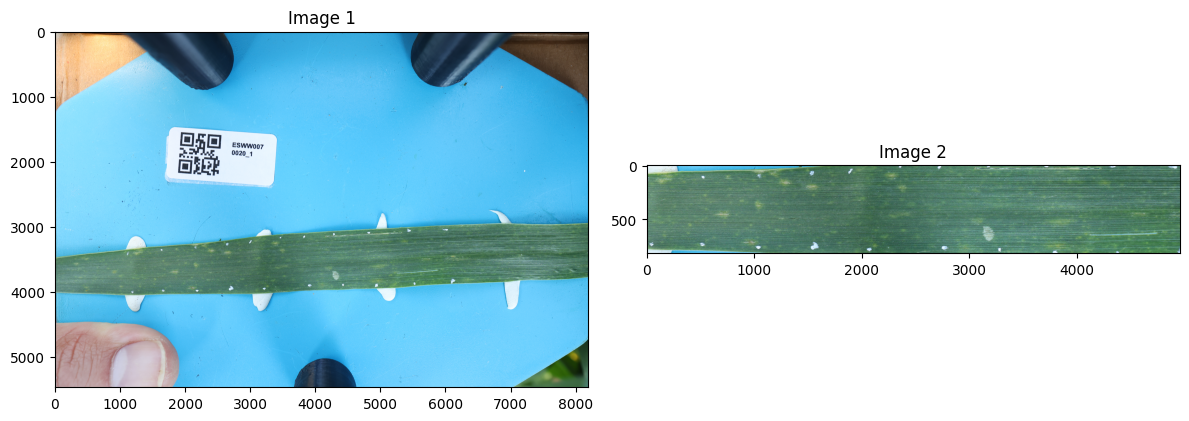

In [42]:
moving_ind=2
img_og = convert_image_to_tensor(leaf.images[moving_ind])
# mask = convert_image_to_tensor(leaf.leaf_masks[moving_img_ind])

H, W = img_og.shape[2], img_og.shape[3]
roi = leaf.rois[moving_ind]
rot_mat = roi["rotation_matrix"]
bbox = roi["bounding_box"]
if rot_mat is None or bbox is None:
    print(f"Error: missing data for leaf {leaf.leaf_uid}")
rot_mat = np.asarray(rot_mat)
bbox = np.asarray(bbox)

img = K.geometry.transform.warp_affine(img_og, torch.Tensor(rot_mat).unsqueeze(0), (H, W)) #, align_corners=True)
img = crop_img(img, bbox[:,0].min(), bbox[:,0].max()-1, bbox[:,1].min(), bbox[:,1].max()-1)

_ = plot_image_pair(img_og, img)

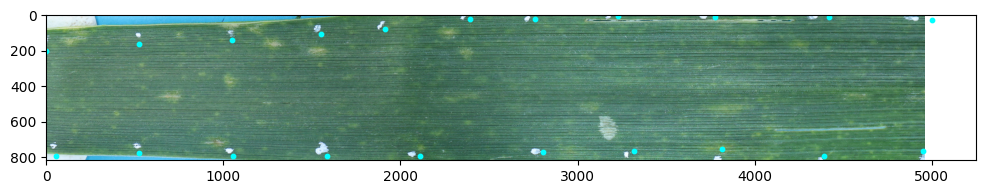

In [43]:
keypoints = leaf.keypoints[moving_ind]
fig = plt.figure(figsize=(12,30))
plt.imshow(K.tensor_to_image(img))
plt.scatter(keypoints[:,0], keypoints[:,1], color="cyan", s=10)
plt.show()

In [44]:
print(f"keypoints x range: {int(min(keypoints[:,0])), int(max(keypoints[:,0]))}")
print(f"keypoints y range: {int(min(keypoints[:,1])), int(max(keypoints[:,1]))}")
print(f"kornia Image dim: {img.shape[2], img.shape[3]}")
print(f"cv Image dim: {img_rot_cv_crop.shape[0], img_rot_cv_crop.shape[1]}")

keypoints x range: (0, 5000)
keypoints y range: (1, 792)
kornia Image dim: (818, 4959)
cv Image dim: (804, 4951)


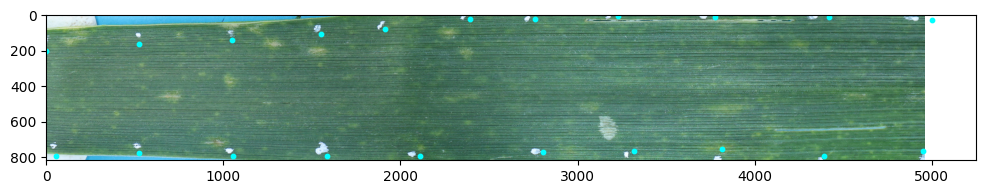

In [45]:
rows, cols = img_og.shape[0], img_og.shape[1]

leaf_np = K.tensor_to_image(img_og)
rows, cols = leaf_np.shape[0], leaf_np.shape[1]
img_rot_cv = cv2.warpAffine(leaf_np, rot_mat, (cols, rows))
img_rot_cv_crop = img_rot_cv[bbox[0][1]:bbox[2][1], bbox[0][0]:bbox[1][0]]

# _ = plot_image_pair(img_og, img_rot_cv_crop)

fig = plt.figure(figsize=(12,30))
plt.imshow(K.tensor_to_image(img))
plt.scatter(keypoints[:,0], keypoints[:,1], color="cyan", s=10)
plt.show()

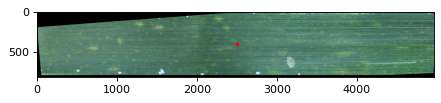

In [46]:
masked_img, mask_t, center = mask_leaf(img, keypoints, erode_px=0, return_center=True, return_bounds=False)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_img))
plt.scatter(center[0], center[1], c='red', s=5, label='center')
# plt.scatter(mean[0][0], mean[0][1], c='yellow', s=5, label='mean')
# plt.scatter(mid[0][0], mid[0][1], c='cyan', s=5, label='middle')
plt.show()


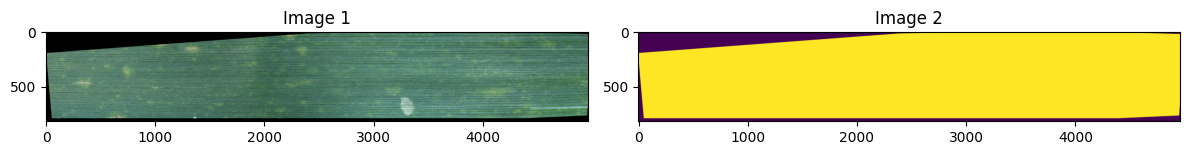

In [52]:
img_scaled = scale_image(masked_img, 1.2, center)
masked_scaled_img = img_scaled * mask_t 
_ = plot_image_pair(masked_scaled_img, mask_t)

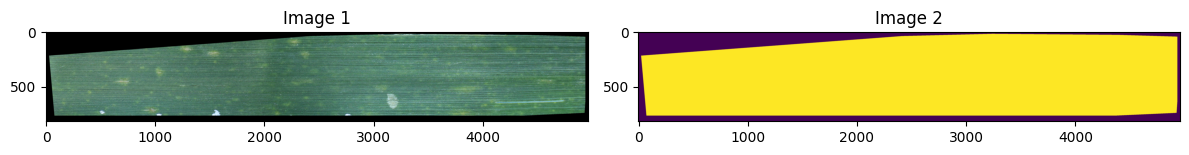

In [51]:
# testing the function
out, mask = crop_ROI_erode_leaf(leaf, moving_ind)
_ = plot_image_pair(out, mask)


## Erosion

### Erosion by Scaling

In [53]:
index = 1
kpts_img = keypoints_roi_to_image(leaf.keypoints[index], leaf.rois[index])
masked_img, mask_t, center, bounds = mask_leaf(leaf.images[index], kpts_img, erode_px=0, return_center=True, return_bounds=True)
bounds

[array([2468, 2726], dtype=int32), array([7462, 3627], dtype=int32)]

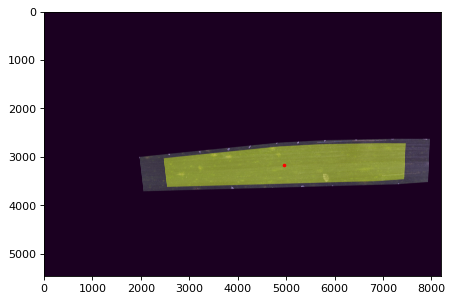

In [55]:
img_scaled = scale_image(masked_img, 1.2, center)

plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(img_scaled))
plt.imshow(K.tensor_to_image(mask_t), alpha=0.4)
plt.scatter(center[0], center[1], c='red', s=5)
plt.show()

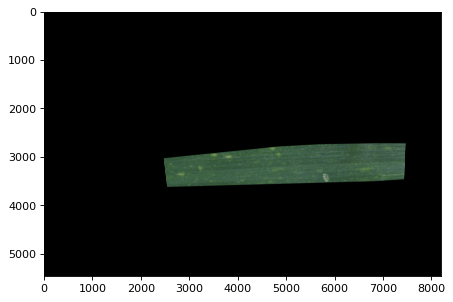

In [56]:
masked_scaled_img = img_scaled * mask_t 
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_scaled_img))
plt.show()

#### Cropping to ROI

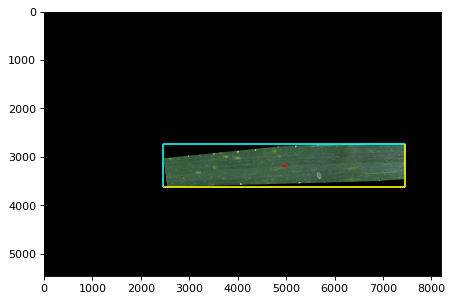

In [57]:
x_min, y_min = bounds[0]
x_max, y_max = bounds[1]
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_img))
plt.scatter(center[0], center[1], c='red', s=5, label='center')
plt.hlines(y=y_min, xmin=x_min, xmax=x_max, colors='cyan')
plt.hlines(y=y_max, xmin=x_min, xmax=x_max, colors='yellow')
plt.vlines(x=x_min, ymin=y_min, ymax=y_max, colors='cyan')
plt.vlines(x=x_max, ymin=y_min, ymax=y_max, colors='yellow')
plt.show()

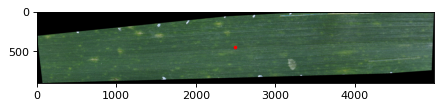

In [58]:
cropped_img, new_center = crop_img(masked_img, x_min, x_max, y_min, y_max, center)
cropped_mask = crop_img(mask_t, x_min, x_max, y_min, y_max)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(cropped_img))
plt.scatter(new_center[0], new_center[1], c='red', s=5, label='center')
plt.show()

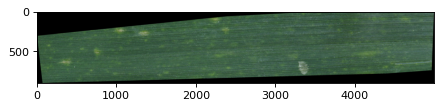

In [59]:
img_scaled = scale_image(cropped_img, 1.2, new_center)
masked_scaled_img = img_scaled * cropped_mask 
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_scaled_img))
plt.show()

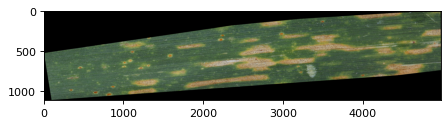

In [60]:
# testing the function
crop_test = erode_crop_leaf(leaf, 13)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(crop_test))
plt.show()

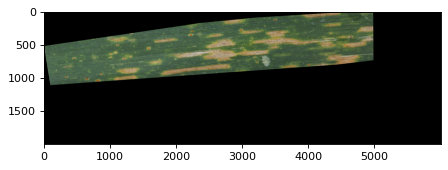

In [61]:
# testing padding
padder = K.augmentation.PadTo((2000,6000))
pad_test = padder(crop_test)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(pad_test))
plt.show()

### Proper Mask Erosion

In [62]:
img = convert_image_to_tensor(img)

B,C,H,W = img.shape
# Computes the convex hull of the keypoints.
hull = cv2.convexHull(keypoints.astype(np.int32)) # Returns ordered list of points forming a polygon that encloses all the keypoints.
# center = np.mean(hull, axis=0)
mins = np.min(hull, axis=0)
maxs = np.max(hull, axis=0)
center = (maxs + mins)/2

# initialize empty mask
mask = np.zeros((H,W), dtype=np.uint8)
cv2.fillConvexPoly(mask, hull.reshape(-1,2), 1) # fill in convex hull with value 1
mask_t = torch.from_numpy(mask).float().to(img.device).unsqueeze(0)
masked_img = img * mask_t

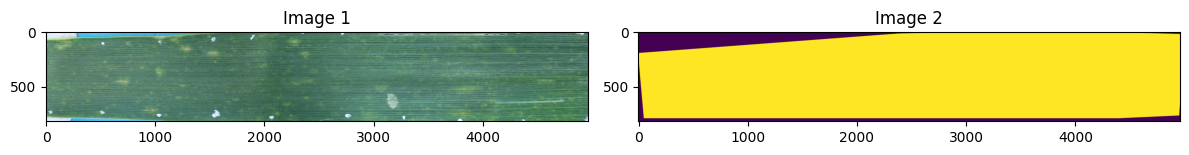

In [63]:
_ = plot_image_pair(img, mask_t)

In [64]:
mask = mask_t.detach().clone()

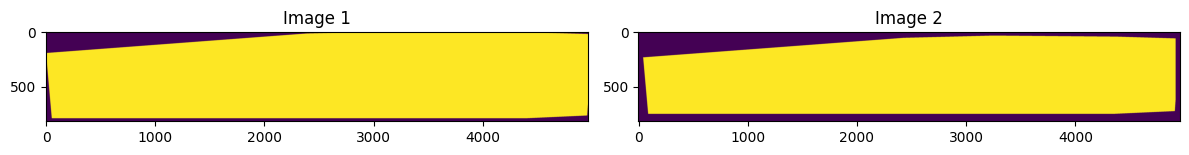

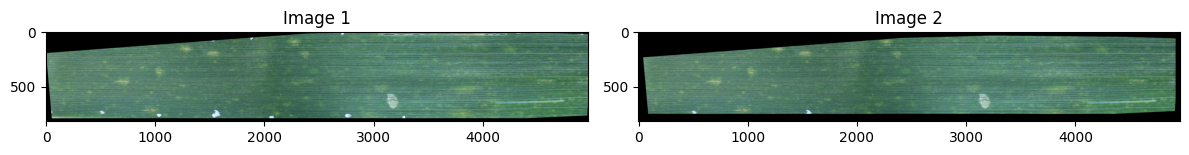

In [65]:
erode_px = 100
mask_t = mask.detach().clone()

kernel = torch.ones((5,5), dtype=torch.float32, device=mask_t.device)
for _ in range(int(erode_px/5)):
    # unsqueeze mask to add batch dim
    mask_t = K.morphology.erosion(mask_t.unsqueeze(0), kernel, border_type='constant').squeeze(0) 
_ = plot_image_pair(mask, mask_t)
test = img*mask_t
_ = plot_image_pair(masked_img, test)

## Fetching Pairs of Registered Images

In [66]:
def fetch_image_mask_pair(leaf, fixed_img_ind, moving_img_ind, method, plot_masked_images=False, plot_loftr_matches=False, old=False):
    if method == "Pairwise Affine":
        img_fixed = convert_image_to_tensor(leaf.target_images[fixed_img_ind])
        mask_fixed = convert_image_to_tensor(leaf.target_masks[fixed_img_ind])
        if (img_fixed is None) or (mask_fixed is None): 
            print(f"Error: missing data for leaf {leaf.leaf_uid}")
            return img_fixed, None, mask_fixed, None
        mask_fixed[mask_fixed != 0] = 1

        img_moving = convert_image_to_tensor(leaf.target_images[moving_img_ind])
        mask_moving = convert_image_to_tensor(leaf.target_masks[moving_img_ind])
        if (img_moving is None) or (mask_moving is None): 
            print(f"Error: missing data for leaf {leaf.leaf_uid}")
            return img_fixed, img_moving, mask_fixed, mask_moving
        mask_moving[mask_moving != 0] = 1
        return img_fixed, img_moving, mask_fixed, mask_moving
        
    else:
        
        if method in ("LoFTR + TPS ROI", "LoFTR + TPS ROI with Markers"):
            # if we want to keep the markers, don't rescale the image
            if old:
                img_scale = {"scale": 1} if method == "LoFTR + TPS ROI with Markers" else {}
            erosion = {"scale": 1, "erode_px": 0} if method == "LoFTR + TPS ROI with Markers" else {"erode_px": 150}


            # fixed image
            if fixed_img_ind == 0:
                img_fixed = convert_image_to_tensor(leaf.images[fixed_img_ind])
                mask_fixed = convert_image_to_tensor(leaf.leaf_masks[fixed_img_ind])

                # if plot_masked_images:
                #     fig, ax = plot_image_pair(img_fixed, mask_fixed, fixed_img_ind, fixed_img_ind, title="Input for fixed image")
                #     fig.show()

                H, W = img_fixed.shape[2], img_fixed.shape[3]
                roi = leaf.rois[fixed_img_ind]
                rot_mat = roi["rotation_matrix"]
                bbox = roi["bounding_box"]
                if rot_mat is None or bbox is None:
                    print(f"Error: missing data for leaf {leaf.leaf_uid}")
                    return None, None, None, None
                rot_mat = np.asarray(rot_mat)
                bbox = np.asarray(bbox)

                img_fixed = K.geometry.transform.warp_affine(img_fixed, torch.Tensor(rot_mat).unsqueeze(0), (H, W)) #, align_corners=True)
                img_fixed = crop_img(img_fixed, bbox[:,0].min(), bbox[:,0].max()-1, bbox[:,1].min(), bbox[:,1].max()-1)
                # img_fixed = img_fixed * mask_fixed
                if old:
                    img_fixed = erode_leaf(img_fixed, mask_fixed, return_mask=False, **img_scale)
                else:
                    img_fixed, mask_fixed = erode_leaf(img_fixed, mask_fixed, return_mask=True, **erosion)

            else:
                if old:
                    img_fixed, mask_fixed = erode_crop_leaf(leaf, fixed_img_ind, return_mask=True, **img_scale)
                else:
                    img_fixed, mask_fixed = crop_ROI_erode_leaf(leaf, fixed_img_ind, return_mask=True, **erosion)
            
            if (img_fixed is None) or (mask_fixed is None): 
                print(f"Error: missing data for leaf {leaf.leaf_uid}")
                return img_fixed, None, mask_fixed, None

            # moving image
            if old:
                img_moving, mask_moving = erode_crop_leaf(leaf, moving_img_ind, return_mask=True, **img_scale)
            else:
                img_moving, mask_moving = crop_ROI_erode_leaf(leaf, moving_img_ind, return_mask=True, **erosion)
            if (img_moving is None) or (mask_moving is None): 
                print(f"Error: missing data for leaf {leaf.leaf_uid}")
                return img_fixed, img_moving, mask_fixed, mask_moving
            size_factor = 2

        elif method in ("LoFTR + TPS Full", "LoFTR + TPS Full with Markers"):
            # if we want to keep the markers, don't rescale the image
            img_scale = {"scale": 1} if method == "LoFTR + TPS ROI with Markers" else {}

            # fixed image
            img_fixed = convert_image_to_tensor(leaf.cropped_images[fixed_img_ind])
            mask_fixed = convert_image_to_tensor(leaf.seg_masks[fixed_img_ind])
            if (img_fixed is None) or (mask_fixed is None): 
                print(f"Error: missing data for leaf {leaf.leaf_uid}")
                return img_fixed, None, mask_fixed, None
            mask_fixed[mask_fixed!=0] = 1
            rmin, rmax, cmin, cmax = crop_coords_zero_borders(mask_fixed)
            img_fixed = crop_img(img_fixed, cmin, cmax, rmin, rmax)
            mask_fixed = crop_img(mask_fixed, cmin, cmax, rmin, rmax)
            img_fixed = erode_leaf(img_fixed, mask_fixed, **img_scale)

            # moving image
            img_moving = convert_image_to_tensor(leaf.cropped_images[moving_img_ind])
            mask_moving = convert_image_to_tensor(leaf.seg_masks[moving_img_ind])
            if (img_moving is None) or (mask_moving is None): 
                print(f"Error: missing data for leaf {leaf.leaf_uid}")
                return img_fixed, img_moving, mask_fixed, mask_moving
            mask_moving[mask_moving!=0] = 1
            rmin, rmax, cmin, cmax = crop_coords_zero_borders(mask_moving)
            img_moving = crop_img(img_moving, cmin, cmax, rmin, rmax)
            mask_moving = crop_img(mask_moving, cmin, cmax, rmin, rmax)
            img_moving = erode_leaf(img_moving, mask_moving, **img_scale)

            size_factor = 4
         
        else:
            raise ValueError(f'Unknown registration method {method}')

        # resize
        height = max(img_fixed.shape[-2], img_moving.shape[-2])
        width = max(img_fixed.shape[-1], img_moving.shape[-1])

        padder = K.augmentation.PadTo((height, width))

        img_fixed = padder(img_fixed)
        img_moving = padder(img_moving)
        mask_fixed = padder(mask_fixed)
        mask_moving = padder(mask_moving)        

        
        H = int(height/size_factor)
        W = int(width/size_factor) 

        img_fixed = K.geometry.resize(img_fixed, (H, W), antialias=True)
        mask_fixed = K.geometry.resize(mask_fixed, (H, W), antialias=False, interpolation='nearest')
        img_moving = K.geometry.resize(img_moving, (H, W), antialias=True)
        mask_moving = K.geometry.resize(mask_moving, (H, W), antialias=False, interpolation='nearest')

        if plot_masked_images:
            fig, ax = plot_image_pair(img_fixed, img_moving, fixed_img_ind, moving_img_ind, title="Masked out input images", title_offset=0.7)
            fig.show()
            fig, ax = plot_image_pair(mask_fixed, mask_moving, fixed_img_ind, moving_img_ind, title="corresponding masks", title_offset=0.7)
            fig.show()


        mkpts0, mkpts1, confidence, _, n_matches = loftr_match(img_fixed, img_moving, verbose=False, return_n_matches=True)

        if plot_loftr_matches:
            # fig, ax = plot_matches(img_fixed, mkpts0, img_moving, mkpts1, inliers, inliers_only=False)
            # fig.show()
            fig, ax = plot_matches_conf(img_fixed, mkpts0, img_moving, mkpts1, confidence, N_show=50, vertical=True)
            fig.show()
            fig, axs = plot_match_coverage(img_fixed, mkpts0, img_moving, mkpts1, confidence)
            fig.show()

        thrsld = 0.5
        
        if n_matches['conf_matches'] > 3:
            warped_moving_img, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, img_moving, verbose=False)
            warped_moving_mask, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, mask_moving, verbose=False)
        else:
            print("No enough matches for TPS found")
            warped_moving_img = None
            warped_moving_mask = None

        return img_fixed, warped_moving_img, mask_fixed, warped_moving_mask
    
    
    # else:
    #     raise ValueError(f'Unknown registration method {method}')

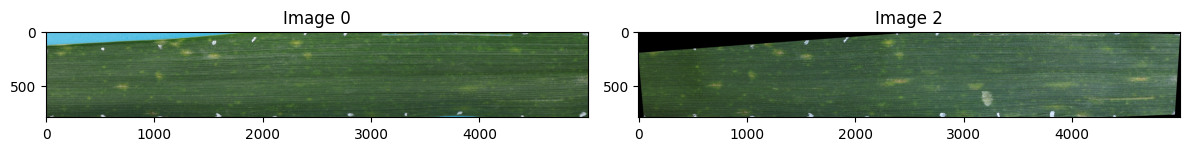

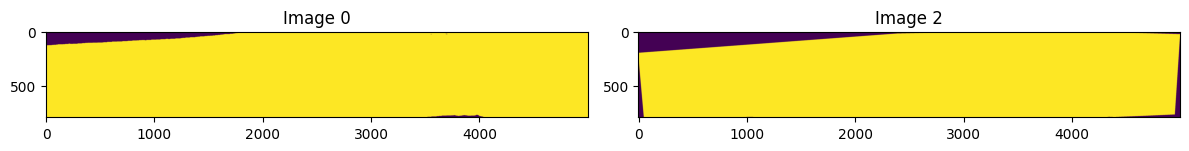

In [67]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, 3, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, 2)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, 2)
fig.show()